# BEE 4750 Homework 4: Linear Programming and Capacity Expansion

**Name**:

**ID**:

> **Due Date**
>
> Thursday, 11/07/23, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to formulate and solve a resource allocation
    problem using linear programming.
-   Problem 2 asks you to formulate, solve, and analyze a standard
    generating capacity expansion problem.
-   Problem 3 (5750 only) asks you to add a CO<sub>2</sub> constraint to
    the capacity expansion problem and identify changes in the resulting
    solution.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [90]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Local/Coding Projects/BEE4570/hw4-late-to-the-party`


In [91]:
using JuMP
using HiGHS
using DataFrames
using Plots
using Measures
using CSV
using MarkdownTables

## Problems (Total: 50/60 Points)

### Problem 1 (20 points)

A farmer has access to a pesticide which can be used on corn, soybeans,
and wheat fields, and costs \$70/ha-yr to apply. The crop yields the
farmer can obtain following crop yields by applying varying rates of
pesticides to the field are shown in
<a href="#tbl-yields" class="quarto-xref">Table 1</a>.

| Application Rate (kg/ha) | Soybean (kg/ha) | Wheat (kg/ha) | Corn (kg/ha) |
|:------------------------:|:---------------:|:-------------:|:------------:|
|            0             |      2900       |     3500      |     5900     |
|            1             |      3800       |     4100      |     6700     |
|            2             |      4400       |     4200      |     7900     |

Table 1: Crop yields from applying varying pesticide rates for Problem
1.

The costs of production, *excluding pesticides*, for each crop, and
selling prices, are shown in
<a href="#tbl-costs" class="quarto-xref">Table 2</a>.

|   Crop   | Production Cost (\$/ha-yr) | Selling Price (\$/kg) |
|:--------:|:--------------------------:|:---------------------:|
| Soybeans |            350             |         0.36          |
|  Wheat   |            280             |         0.27          |
|   Corn   |            390             |         0.22          |

Table 2: Costs of crop production, excluding pesticides, and selling
prices for each crop.

Recently, environmental authorities have declared that farms cannot have
an *average* application rate on soybeans, wheat, and corn which exceeds
0.8, 0.7, and 0.6 kg/ha, respectively. The farmer has asked you for
advice on how they should plant crops and apply pesticides to maximize
profits over 130 total ha while remaining in regulatory compliance if
demand for each crop (which is the maximum the market would buy) this
year is 250,000 kg?

**In this problem**:

-   Formulate a linear program for this resource allocation problem,
    including clear definitions of decision variable(s) (including
    units), objective function(s), and constraint(s) (make sure to
    explain functions and constraints with any needed derivations and
    explanations). **Tip: Make sure that all of your constraints are
    linear**.
-   Implement the program in `JuMP.jl` and find the solution. How many
    ha should the farmer dedicate to each crop and with what pesticide
    application rate(s)? How much profit will the farmer expect to make?
-   The farmer has an opportunity to buy an extra 10 ha of land. How
    much extra profit would this land be worth to the farmer? Discuss
    why this value makes sense and whether you would recommend the
    farmer should make the purchase.



Decision variables:
$x_{c,p}$ $c \in {1, 2, 3}   p \in {0,1,2}$ (amount of each crop and pesticide dosage combination to plant, 1 is soy, 2 is wheat, 3 is corn)

Constants:

$y_{c,p}$ $c \in {1, 2, 3}  p \in {0,1,2}$ (yield for each crop and pesticide combination)

$c_c c \in {1, 2, 3}$ (production cost for each crop)

$p_c c \in {1, 2, 3}$ (selling price for each crop)

$c_p$ (cost of pesticide)

$l_c c \in {1, 2, 3}$ (limit on pesticide application for each crop)

$a$ (total area of land)

$d_{max}$ (maximum demand for each crop)


Problem formulation:

max $ \sum_{i=1}^{3} \sum_{j=0}^{2} x_{i,j} \times (y_{i,j} \times p_i - c_i - j \times c_p)$

subject to

$\sum_{i=1}^{3} \sum_{j=0}^{2} x_{i,j} \leq a $

$\frac{\sum_{j=0}^{2} x_{i,j} \times i}{\sum_{j=0}^{2} x_{i,j}} \leq l_i  \forall i \in {1,2,3}$

$\sum_{j=1}^{2} x_{i,j} \times y_{i,j} \leq d_{max} \forall i \in {1,2,3}$

In [92]:
model = Model(HiGHS.Optimizer)

@variable(model, 0 <= S[0:2] <= 130)    # S0-2 is x c = 1, p = 0, 1, 2
@variable(model, 0 <= W[0:2] <= 130)    # etc
@variable(model, 0 <= C[0:2] <= 130)

a = 130

@objective(model, Max, S[0]*(2900*0.36-350-0) + S[1]*(3800*0.36-350-1*70) + S[2]*(4400*0.36-450-2*70) + W[0]*(3500*0.27-280-0) + W[1]*(4100*0.27-280-1*70) + W[2]*(4200*0.27-380-2*70) + C[0]*(5900*0.22-390-0) + C[1]*(6700*0.22-390-1*70) + C[2]*(7900*0.22-390-2*70))

@constraint(model, land, sum(S[0:2]) + sum(W[0:2]) + sum(C[0:2]) <= a)

@constraint(model, S_demand, 2900*S[0] + 3800*S[1] + 4400*S[2] <= 250000)
@constraint(model, W_demand, 3500*W[0] + 4100*W[1] + 4200*W[2] <= 250000)
@constraint(model, C_demand, 5900*C[0] + 6700*C[1] + 7900*C[2] <= 250000)

@constraint(model, S_avg, (S[1] + 2*S[2]) <= 0.8 * sum(S[0:2]))
@constraint(model, W_avg, (W[1] + 2*W[2]) <= 0.7 * sum(W[0:2]))
@constraint(model, C_avg, (C[1] + 2*C[2]) <= 0.6 * sum(C[0:2]))

optimize!(model)

value.(all_variables(model))


Running HiGHS 1.7.2 (git hash: 5ce7a2753): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [2e-01, 8e+03]
  Cost   [6e+02, 1e+03]
  Bound  [1e+02, 1e+02]
  RHS    [1e+02, 2e+05]
Presolving model
7 rows, 9 cols, 27 nonzeros  0s
7 rows, 9 cols, 27 nonzeros  0s
Presolve : Reductions: rows 7(-0); columns 9(-0); elements 27(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
          9     1.1674116702e+05 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 9
Objective value     :  1.1674116702e+05
HiGHS run time      :          0.00


9-element Vector{Float64}:
 13.812154696132595
 55.24861878453038
  0.0
  6.743306417339571
 15.734381640458995
  0.0
 26.923076923076916
  0.0
 11.538461538461538

The output of the optimized model gives the following results:

Soybeans:
- 13.81 acres at rate 0
- 55.25 acres at rate 1
- 0.0   acres at rate 2

Wheat:
- 6.74  acres at rate 0
- 15.73 acres at rate 1
- 0.0   acres at rate 2

Corn:
- 26.92 acres at rate 0
- 0.0   acres at rate 1
- 11.54 acres at rate 2

Which will produce a profit of $116,741

In [93]:
model = Model(HiGHS.Optimizer)

@variable(model, 0 <= S[0:2] <= 130)    # S0-2 is x c = 1, p = 0, 1, 2
@variable(model, 0 <= W[0:2] <= 130)    # etc
@variable(model, 0 <= C[0:2] <= 130)

a = 140

@objective(model, Max, S[0]*(2900*0.36-350-0) + S[1]*(3800*0.36-350-1*70) + S[2]*(4400*0.36-450-2*70) + W[0]*(3500*0.27-280-0) + W[1]*(4100*0.27-280-1*70) + W[2]*(4200*0.27-380-2*70) + C[0]*(5900*0.22-390-0) + C[1]*(6700*0.22-390-1*70) + C[2]*(7900*0.22-390-2*70))

@constraint(model, land, sum(S[0:2]) + sum(W[0:2]) + sum(C[0:2]) <= a)

@constraint(model, S_demand, 2900*S[0] + 3800*S[1] + 4400*S[2] <= 250000)
@constraint(model, W_demand, 3500*W[0] + 4100*W[1] + 4200*W[2] <= 250000)
@constraint(model, C_demand, 5900*C[0] + 6700*C[1] + 7900*C[2] <= 250000)

@constraint(model, S_avg, (S[1] + 2*S[2]) <= 0.8 * sum(S[0:2]))
@constraint(model, W_avg, (W[1] + 2*W[2]) <= 0.7 * sum(W[0:2]))
@constraint(model, C_avg, (C[1] + 2*C[2]) <= 0.6 * sum(C[0:2]))

optimize!(model)

value.(all_variables(model))

Running HiGHS 1.7.2 (git hash: 5ce7a2753): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [2e-01, 8e+03]
  Cost   [6e+02, 1e+03]
  Bound  [1e+02, 1e+02]
  RHS    [1e+02, 2e+05]
Presolving model
7 rows, 9 cols, 27 nonzeros  0s
7 rows, 9 cols, 27 nonzeros  0s
Presolve : Reductions: rows 7(-0); columns 9(-0); elements 27(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
          7     1.2403516702e+05 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 7
Objective value     :  1.2403516702e+05
HiGHS run time      :          0.00


9-element Vector{Float64}:
 13.812154696132591
 55.24861878453038
  0.0
  9.743306417339577
 22.734381640459006
  0.0
 26.92307692307691
  0.0
 11.538461538461535

The output of this second optimized model with 10 more ha of land gives the following results:

Soybeans:
- 13.81 acres at rate 0
- 55.25 acres at rate 1
- 0.0   acres at rate 2 

Wheat:
- 9.74  acres at rate 0 << increase
- 22.73 acres at rate 1 << increase
- 0.0   acres at rate 2

Corn:
- 26.92 acres at rate 0
- 0.0   acres at rate 1
- 11.54 acres at rate 2

Which will produce a profit of $124,035. This is an increase of about $7,294. This makes sense, because in the previous example, the maximum demand constraints on both corn and soy were active, so only more wheat could be planted. Averaging the profit per acre of wheat for treatments 0, 1, and 2, and multiplying by 10 acres, we get $7,800, which is close to the increased profit.

### Problem 2 (30 points)

For this problem, we will use hourly load (demand) data from 2013 in New
York’s Zone C (which includes Ithaca). The load data is loaded and
plotted below in <a href="#fig-demand" class="quarto-xref">Figure 1</a>.

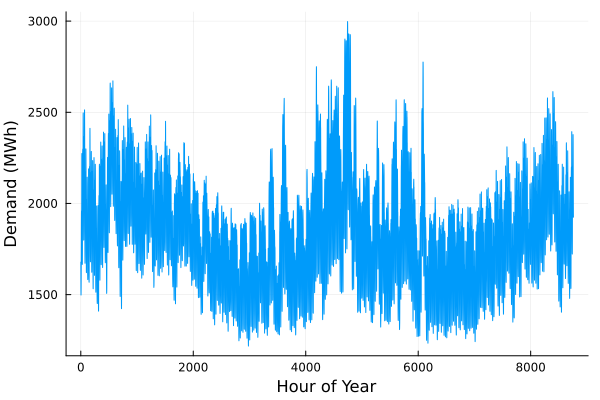

In [94]:
# load the data, pull Zone C, and reformat the DataFrame
NY_demand = DataFrame(CSV.File("data/2013_hourly_load_NY.csv"))
rename!(NY_demand, :"Time Stamp" => :Date)
demand = NY_demand[:, [:Date, :C]]
rename!(demand, :C => :Demand)
demand[:, :Hour] = 1:nrow(demand)

# plot demand
plot(demand.Hour, demand.Demand, xlabel="Hour of Year", ylabel="Demand (MWh)", label=:false)

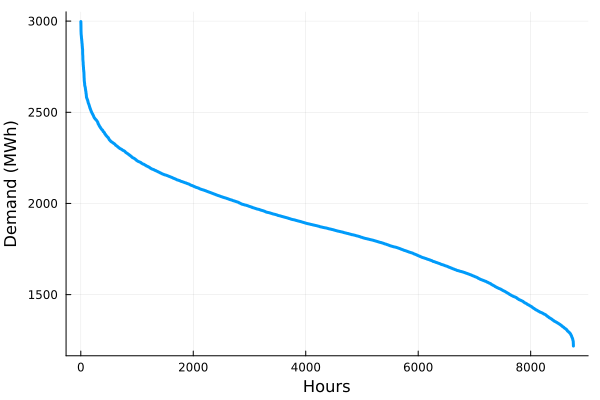

In [95]:
# Plot demand sorted from low to high
plot(sort(demand.Demand, rev=true), linewidth=3, label=:false)
xaxis!("Hours")
yaxis!("Demand (MWh)")

Next, we load the generator data, shown in
<a href="#tbl-generators" class="quarto-xref">Table 3</a>. This data
includes fixed costs (\$/MW installed), variable costs (\$/MWh
generated), and CO<sub>2</sub> emissions intensity (tCO<sub>2</sub>/MWh
generated).

In [96]:
gens = DataFrame(CSV.File("data/generators.csv"))

6×4 DataFrame
 Row │ Plant       FixedCost  VarCost  Emissions 
     │ String15    Int64      Int64    Float64   
─────┼───────────────────────────────────────────
   1 │ Geothermal     450000        0       0.0
   2 │ Coal           220000       24       1.0
   3 │ NG CCGT         82000       30       0.43
   4 │ NG CT           65000       40       0.55
   5 │ Wind            91000        0       0.0
   6 │ Solar           70000        0       0.0

Finally, we load the hourly solar and wind capacity factors, which are
plotted in <a href="#fig-cf" class="quarto-xref">Figure 2</a>. These
tell us the fraction of installed capacity which is expected to be
available in a given hour for generation (typically based on the average
meteorology).

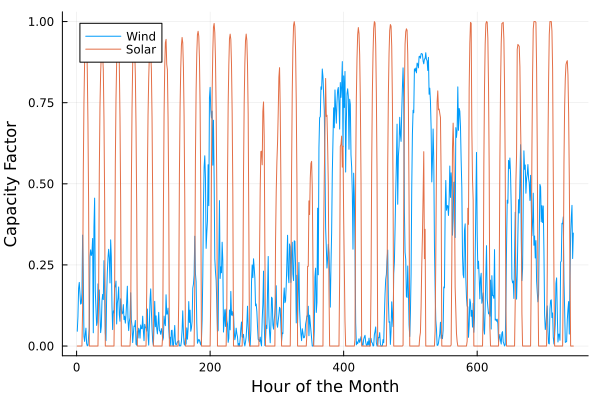

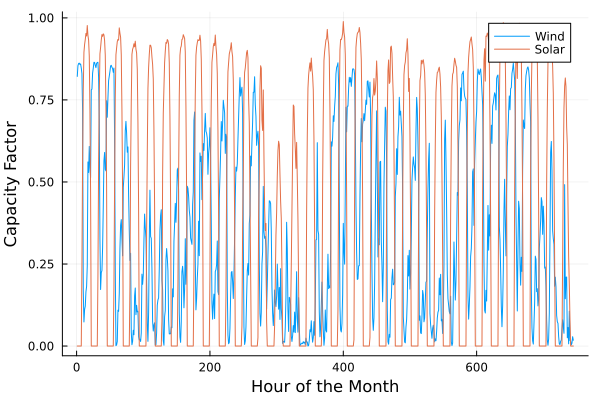

In [97]:
# load capacify factors into a DataFrame
cap_factor = DataFrame(CSV.File("data/wind_solar_capacity_factors.csv"))

# plot January capacity factors
p1 = plot(cap_factor.Wind[1:(24*31)], label="Wind")
plot!(cap_factor.Solar[1:(24*31)], label="Solar")
xaxis!("Hour of the Month")
yaxis!("Capacity Factor")

p2 = plot(cap_factor.Wind[4344:4344+(24*31)], label="Wind")
plot!(cap_factor.Solar[4344:4344+(24*31)], label="Solar")
xaxis!("Hour of the Month")
yaxis!("Capacity Factor")

p2 = plot(cap_factor.Wind[4344:4344+(24*31)], label="Wind")
plot!(cap_factor.Solar[4344:4344+(24*31)], label="Solar")
xaxis!("Hour of the Month")


display(p1)
display(p2)

You have been asked to develop a generating capacity expansion plan for
the utility in Riley County, NY, which currently has no existing
electrical generation infrastructure. The utility can build any of the
following plant types: geothermal, coal, natural gas combined cycle gas
turbine (CCGT), natural gas combustion turbine (CT), solar, and wind.

While coal, CCGT, and CT plants can generate at their full installed
capacity, geothermal plants operate at maximum 85% capacity, and solar
and wind available capacities vary by the hour depend on the expected
meteorology. The utility will also penalize any non-served demand at a
rate of \$10,000/MWh.

**In this problem**:

-   Formulate a linear program for this capacity expansion problem,
    including clear definitions of decision variable(s) (including
    units), objective function(s), and constraint(s) (make sure to
    explain functions and constraints with any needed derivations and
    explanations).
-   Implement your linear program in `JuMP.jl`. Find the optimal
    solution. How much should the utility build of each type of
    generating plant? What will the total cost be? How much energy will
    be non-served?
-   What fraction of annual generation does each plant type produce? How
    does this compare to the breakdown of built capacity that you found
    in Problem 1.5? Do these results make sense given the generator
    data?
-   Make a plot of the electricity price in each hour. Discuss any
    trends that you see.

> **Significant Digits**
>
> Use `round(x; digits=n)` to report values to the appropriate
> precision! If your number is on a different order of magnitude and you
> want to round to a certain number of significant digits, you can use
> `round(x; sigdigits=n)`.

> **Getting Variable Output Values**
>
> `value.(x)` will report the values of a `JuMP` variable `x`, but it
> will return a special container which holds other information about
> `x` that is useful for `JuMP`. This means that you can’t use this
> output directly for further calculations. To just extract the values,
> use `value.(x).data`.

> **Suppressing Model Command Output**
>
> The output of specifying model components (variable or constraints)
> can be quite large for this problem because of the number of time
> periods. If you end a cell with an `@variable` or `@constraint`
> command, I *highly* recommend suppressing output by adding a
> semi-colon after the last command, or you might find that your
> notebook crashes.

Decision variables:

$x_g g \in {1,2,3,4,5,6}$ installed capacity of each generator type representing geothermal, coal, CCGT, CT, solar, and wind respectively.

$NSE_t$ non-served energy in hour t

Other variables:

$y_{g,t}$ production from each generator type g in hour t

$CapFac_{g,t}$ capacity factor of generator type g at time t

$y_{g,t} = x_g \times CapFac_{g,t}$ which reflects the capacity factors of certain generator types (geothermal, solar, wind) that have operating efficiencies below 1

$FixedCost_g$ which is the cost of a certain MWh installation of generator type $g$

$VarCost_g$ which is the cost of producing MWh with generator $g$

$NSECost$ which is the cost of non-served energy

$d_t$ demand at time t

min $\sum_{g \in G} FixedCost_g \times x_g + \sum_{t \in T} \sum_{g \in G} VarCost_g \times y_{g,t} + \sum_{t in T} NSECost \times NSE_t$

subject to

$\sum_{g \in G} y_g,t + NSE_t \geq d_t \forall T$

$y_{g,t} \leq x_g \forall g \in G, \forall t \in T$

$x_g,y_{g,t},NSE_t \geq 0 \forall g \in G, \forall t \in T$

$y_{g,t} \leq x_g \times CapFac_{g,t} \text{ where } g=1,5,6, \forall t \in T$

In [ ]:
# sets
T = 1:nrow(demand)
G = 1:nrow(gens[1:end, :])
NSECost = 10000

#model
gencap = Model(HiGHS.Optimizer)

@variables(gencap, begin
    x[g in G] >= 0
    y[g in G, t in T] >= 0
    NSE[t in T] >= 0
end)

@objective(gencap, Min, 
    sum(gens[G, :FixedCost] .* x) + sum(gens[G, :VarCost] .* sum(y[:, t] for t in T)) + NSECost * sum(NSE)
)

@constraint(gencap, load[t in T], sum(y[:, t]) + NSE[t] >= demand.Demand[t])        # Meet demand (or produce NSE)
@constraint(gencap, availability[g in G, t in T], y[g, t] <= x[g])                  # 2nd constraint: must be within installed capacity

# Capacity factors for renewables
@constraint(gencap, geotherm[t in T], y[1,t] <= 0.85 * x[1])
@constraint(gencap, capfac_wind[t in T], y[5,t] <= cap_factor.Wind[t] * x[5])
@constraint(gencap, capfac_solar[t in T], y[6,t] <= cap_factor.Solar[t] * x[6])

optimize!(gencap)

sum(value.(y).data[2,:])

Installed capacities and percent built capacities are:
- 0 MWh Geothermal  0%
- 0 MWh Coal        0%
- 1658.45 MWh CGCT  33%
- 879.75 MWh CT     18%
- 484.95 MWh Solar  10%
- 1957.64 MWh Wind  39%

And the actual generation and contributions are:
- CCGT:  8.65 e6
- CT:    449375.8
- Wind:  1.41
- Solar: 5.85 ??

Total optimal cost is $654.5m.

By finding `sum(value.(NSE).data)` it was clear that about 256.83 MWh of energy were non-served.

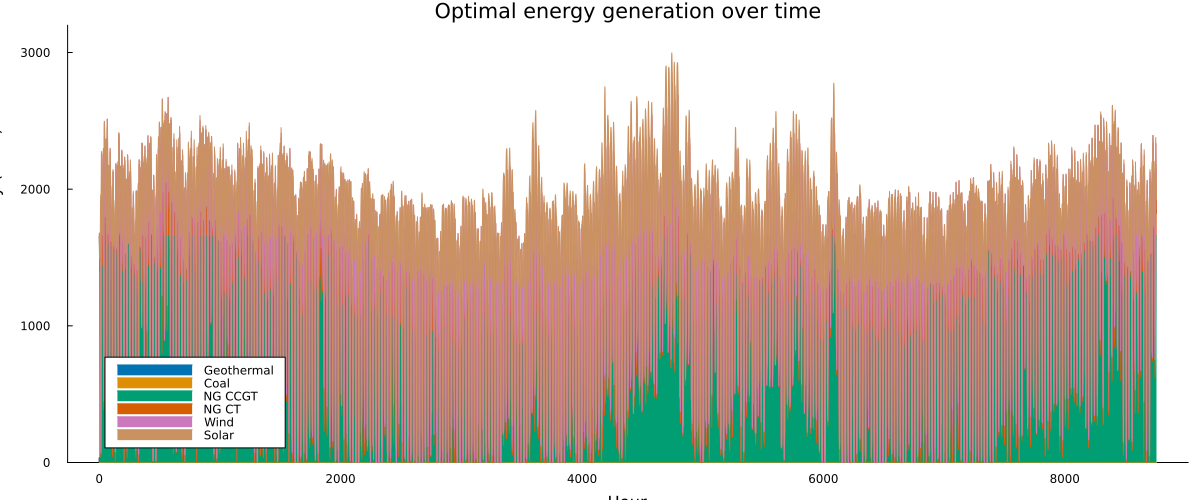

In [133]:
p = areaplot(value.(y).data', 
    label=permutedims(gens.Plant), 
    xlabel = "Hour", 
    ylabel ="Generated Electricity (MWh)", 
    color_palette=:seaborn_colorblind,
    grid=:false,
    legend = :bottomleft)
ylims!(p, (0, 3200))
title!("Optimal energy generation over time")
plot!(p, size=(1200, 500))

### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

The NY state legislature is considering enacting an annual
CO<sub>2</sub> limit, which for the utility would limit the emissions in
its footprint to 1.5 MtCO<sub>2</sub>/yr.

**In this problem**:

-   Reformulate your linear program from Problem 2 with any necessary
    changes to capture the CO<sub>2</sub> limit.
-   Implement the new optimization problem and find the optimal
    solution. How much should the utility build of each type of
    generating plant? What is different from your plan from Problem 1?
    Do these changes make sense?
-   What would the value to the utility be of allowing it to emit an
    additional 1000 tCO<sub>2</sub>/yr? An additional 5000?

## References

List any external references consulted, including classmates.